In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
from copy import deepcopy
import seaborn as sns

# required only for jupyter notebooks / while running on colab
%matplotlib inline

# set seed
seed = 42
np.random.seed(seed)

# Part 1 - MLP for Regression (Spotify Song Popularity)

In this part, we will build a **4-layer** MLP to predict song popularity.

## 1.1 Data Loading and Preprocessing

This section prepares the dataset for a regression task on Spotify song popularity.

It includes feature selection, data cleaning, normalization, and train–test splitting,formatted to match the expected input structure of a fully connected neural network.


In [2]:
# Load the dataset
try:
    spotify_df = pd.read_csv('tracks.csv')
    
    # The tracks.csv has 'release_date', so we create 'year' from it
    if 'year' not in spotify_df.columns and 'release_date' in spotify_df.columns:
        spotify_df['year'] = pd.to_datetime(spotify_df['release_date'], errors='coerce').dt.year

except FileNotFoundError:
    print("Dataset file 'tracks.csv' not found.")
    print("Falling back to a synthetic dataset for pipeline validation.")
    spotify_df = pd.DataFrame(np.random.rand(100, 14), 
                              columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 
                                       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 
                                       'key', 'mode', 'explicit', 'year'])

# Select features (X) and target (Y)
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 
            'key', 'mode', 'explicit', 'year']
target = 'popularity'

# Drop NAs
spotify_df = spotify_df.dropna(subset=features + [target])

# Ensure numeric types
for col in features + [target]:
    spotify_df[col] = pd.to_numeric(spotify_df[col], errors='coerce')
    
spotify_df = spotify_df.dropna()

# For performance, we'll sample 30,000 tracks
if len(spotify_df) > 30000:
    spotify_df = spotify_df.sample(n=30000, random_state=seed)

X_spotify = spotify_df[features]
Y_spotify = spotify_df[[target]]

# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_spotify_scaled = scaler_X.fit_transform(X_spotify)
Y_spotify_scaled = scaler_Y.fit_transform(Y_spotify)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_spotify_scaled, Y_spotify_scaled, test_size=0.2, random_state=seed)

# Transpose for our NN architecture: (features, num_examples)
x_train_reg = X_train_reg.T
y_train_reg = y_train_reg.T
x_test_reg = X_test_reg.T
y_test_reg = y_test_reg.T

print(f"X_train_reg shape: {x_train_reg.shape}")
print(f"y_train_reg shape: {y_train_reg.shape}")
print(f"(Input features, 'I' = {x_train_reg.shape[0]})")

X_train_reg shape: (13, 24000)
y_train_reg shape: (1, 24000)
(Input features, 'I' = 13)


## 1.2 MLP Architecture

**Architecture:** `input - FC - ReLU - FC - ReLU - FC - ReLU - FC - Output`

The output activation is also ReLU (for Regression) to ensure our prediction `popularity` is non-negative.

**Dimensions (Example):**
* `I`: Input features (13 for Spotify)
* `H1`: 64 neurons
* `H2`: 32 neurons
* `H3`: 16 neurons
* `O`: Output Layer (1 for this regression task)

### 1.3 Helper: Parameter Initialization (He Initialization)

To ensure the network learns effectively using ReLU activations, we must initialize weights carefully. If weights are too small, gradients vanish. If too large, they explode.


In [3]:
def Initialization(I, H1, H2, H3, O):
    '''
    Initializes weights using He Initialization (optimized for ReLU).
    
    Inputs:
        I, H1, H2, H3, O: Number of neurons in each layer.
        
    Returns:
        List of parameters: [W1, b1, W2, b2, W3, b3, W4, b4]
    '''
    np.random.seed(42) # Ensure reproducibility

    # Calculate scaling factors for He Initialization
    scale1 = np.sqrt(2.0 / I)
    scale2 = np.sqrt(2.0 / H1)
    scale3 = np.sqrt(2.0 / H2)
    scale4 = np.sqrt(2.0 / H3)
    
    # Layer 1: Input -> Hidden 1
    W1 = np.random.randn(H1, I) * scale1
    b1 = np.zeros((H1, 1)) 
    
    # Layer 2: Hidden 1 -> Hidden 2
    W2 = np.random.randn(H2, H1) * scale2
    b2 = np.zeros((H2, 1))
    
    # Layer 3: Hidden 2 -> Hidden 3
    W3 = np.random.randn(H3, H2) * scale3
    b3 = np.zeros((H3, 1))
    
    # Layer 4: Hidden 3 -> Output
    W4 = np.random.randn(O, H3) * scale4
    b4 = np.zeros((O, 1))
    
    print("Parameters initialized with He Initialization.")
    return [W1, b1, W2, b2, W3, b3, W4, b4]

In [4]:
#Sample test case
np.random.seed(seed)
params_list = Initialization(13, 64, 32, 16, 1)
assert len(params_list) == 8
assert params_list[0].shape == (64, 13) 
assert params_list[1].shape == (64, 1)  
assert params_list[6].shape == (1, 16)  
assert np.mean(params_list[0]) < 0.1 and np.mean(params_list[0]) > -0.1
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.4 Activation Function (ReLU)


In [5]:
# x: activation input of shape (n_units, m)
def relu(x):
    # Element-wise ReLU activation
    return np.maximum(x, 0)

def drelu(x):
    # Boolean mask for element-wise derivative of ReLU
    return (x > 0).astype(int)

In [6]:
# sample test case
x_sample = np.array([[3, -4], [0, -0.5]])   #two samples with the values of its two fetchers.
assert np.allclose(relu(x_sample), np.array([[3, 0], [0, 0]]))
assert np.allclose(drelu(x_sample), np.array([[1, 0], [0, 0]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## 1.5 Forward Propagation


In [7]:
import numpy as np


def feed_forward(X, params):
    '''
    Inputs:
    - X : Input data of shape (I, num_examples)
    - params: List of parameters [W1, b1, W2, b2, W3, b3, W4, b4]

    Outputs:
    - y_out : predicted output (A4), shape (O, num_examples)
    - cache : List containing [Z1, A1, Z2, A2, Z3, A3, Z4, A4]
    '''
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    cache = []
    A0 = X
    Z1 = W1 @ A0 + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)
    Z3 = W3 @ A2 + b3
    A3 = relu(Z3)
    Z4 = W4 @ A3 + b4
    A4 = relu(Z4)
    for x in [Z1,A1,Z2,A2,Z3,A3,Z4,A4]:
        cache.append(x)

    y_out = A4 
    return y_out, cache

In [8]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 13, 64, 32, 16, 1, 100
params_list = Initialization(I, H1, H2, H3, O)
X_sample = np.random.rand(I, m)
y_forward, cache = feed_forward(X_sample, params_list)

assert y_forward.shape == (O, m)
assert len(cache) == 8 
assert cache[0].shape == (H1, m) 
assert cache[7].shape == (O, m) 
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.6: Loss Function (MSE)


In [9]:
def loss_compute(y_pred, yd):
    '''
    Inputs:
    - y_pred: (O, m) numpy array of predicted values
    - yd: (O, m) numpy array of true values

    Outputs:
    - loss: The MSE loss (scalar)
    '''
    m = yd.shape[1]
    loss = 1/(2*m) * np.sum((y_pred - yd)**2)
    return loss


In [10]:
sample_loss = loss_compute(np.array([[1, 1, 4]]), np.array([[1, 0, 2]]))
print(sample_loss)
assert np.allclose(sample_loss, 0.8333333333333334)

print('Sample Test passed', '\U0001F44D')

0.8333333333333333
Sample Test passed 👍


## 1.7 L2 Regularization

In [11]:
def regularization_L2(lmbda, W1, W2, W3, W4, m):
    '''
    Inputs:
    - lmbda: Regularization parameter (lambda)
    - W1, W2, W3, W4: Weight matrices
    - m: number of examples

    Outputs:
    - reg_loss: The L2 regularization cost (scalar)
    '''

    reg_loss = (lmbda/(2*m))*(np.sum(W1**2)+ np.sum(W2**2)+ np.sum(W3**2)+ np.sum(W4**2))
    return reg_loss

In [12]:
# TEST CASE 1
w1 = np.array([[1, 1], [1, 1]])
w2 = np.array([[1, 1], [1, 1]])
w3, w4 = w1.copy(), w2.copy()
# print(regularization_L2(0.1, w1, w2, w3, w4, 2))
assert np.allclose(regularization_L2(0.1, w1, w2, w3, w4, 2), 0.4)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## 1.8 Backpropagation

In [13]:
def Backpropagation_reg(X, yd, cache, parameters, lmbda):
    '''
    Performs the backward pass for the 4-layer network (Regression version).

    Inputs:
      - X: Input features (I, m)
      - yd: True labels (O, m)
      - cache: List from feed_forward [Z1, A1, Z2, A2, Z3, A3, Z4, A4]
      - parameters: List of parameters [W1, b1, W2, b2, W3, b3, W4, b4]
      - lmbda: regularization parameter

    Outputs:
      - grads: Dictionary of gradients { "dW1": dW1, "db1": db1, ... }
    '''
    m = X.shape[1]
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = cache
    grads = {}

    # Layer 4
    dA4 = (1/m) * (A4 - yd)               # gradient of loss w.r.t A4
    dZ4 = dA4 * drelu(Z4)                 # element-wise
    dW4 = dZ4 @ A3.T + (lmbda/m) * W4
    db4 = np.sum(dZ4, axis=1, keepdims=True)
    # propagate to previous layer
    dA3 = W4.T @ dZ4                      # gradient w.r.t A3

    # Layer 3
    dZ3 = dA3 * drelu(Z3)
    dW3 = dZ3 @ A2.T + (lmbda/m) * W3
    db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = W3.T @ dZ3

    # Layer 2
    dZ2 = dA2 * drelu(Z2)
    dW2 = dZ2 @ A1.T + (lmbda/m) * W2
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = W2.T @ dZ2

    # Layer 1
    dZ1 = dA1 * drelu(Z1)
    dW1 = dZ1 @ X.T + (lmbda/m) * W1       # A0 = X
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    grads['dW4'] = dW4
    grads['db4'] = db4

    return grads

In [14]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 13, 64, 32, 16, 1, 100
params_list = Initialization(I, H1, H2, H3, O)
X_sample = np.random.rand(I, m)
Y_sample = np.random.rand(O, m)
y_forward, cache = feed_forward(X_sample, params_list)
grads = Backpropagation_reg(X_sample, Y_sample, cache, params_list, lmbda=0.1)

assert grads['dW1'].shape == (H1, I)
assert grads['db1'].shape == (H1, 1)
assert grads['dW4'].shape == (O, H3)
assert grads['db4'].shape == (O, 1)
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 1.9 Training the Model (Regression)


In [15]:
def training_reg(X, yd, parameters, eta = 0.01, num_iters=3000, lmbda = 0.1):
    '''
      Inputs:
      - X: Input features (I, m)
      - yd: True labels (O, m)
      - parameters: Initialized parameters list
      - eta: learning rate
      - num_iters: number of iterations
      - lmbda: regularization parameter

      Outputs:
      - losses: list of total loss at each iteration
      - parameters: the final trained parameters list
    '''
    losses = []
    m = X.shape[1]
    
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters

    for i in tqdm(range(num_iters)):
      y_out ,cache = feed_forward(X,parameters)
      loss = loss_compute(y_out , yd)
      reg_loss = regularization_L2(lmbda, W1, W2, W3, W4, m)
      total_loss = loss + reg_loss
      losses.append(total_loss)
      grads = Backpropagation_reg(X, yd, cache, parameters, lmbda)
      W1-=eta*grads["dW1"]
      b1-=eta*grads["db1"]
      W2-=eta*grads["dW2"]
      b2-=eta*grads["db2"]
      W3-=eta*grads["dW3"]
      b3-=eta*grads["db3"]
      W4-=eta*grads["dW4"]
      b4-=eta*grads["db4"]
    # Pack parameters back into a list
    parameters_final = [W1, b1, W2, b2, W3, b3, W4, b4]
    return losses, parameters_final

Parameters initialized with He Initialization.


100%|██████████| 300/300 [00:23<00:00, 12.72it/s]


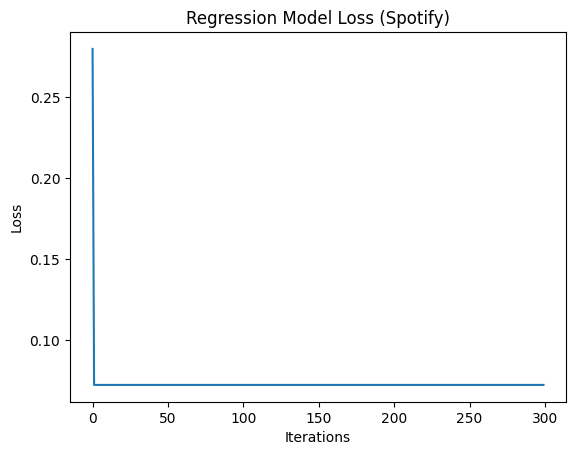

In [16]:
I = x_train_reg.shape[0]
O = y_train_reg.shape[0]
H1, H2, H3 = 64, 32, 16

np.random.seed(seed)
init_params_reg = Initialization(I, H1, H2, H3, O)

# 300 iterations is just for testing. For a good result, try 3000-5000.
losses_reg, params_reg = training_reg(x_train_reg, y_train_reg, init_params_reg, eta=0.05, num_iters=300, lmbda=0.01)
plt.plot(losses_reg)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Regression Model Loss (Spotify)')
plt.show()

In [17]:
#Sample test case
y_pred_test_reg, _ = feed_forward(x_test_reg, params_reg)
test_loss = loss_compute(y_pred_test_reg, y_test_reg)
print(f"Final Test MSE (Spotify): {test_loss}")

assert losses_reg[-1] < losses_reg[0], "Loss should decrease!"
print('Sample Test passed', '\U0001F44D')

Final Test MSE (Spotify): 0.07102153237240075
Sample Test passed 👍


# Part 2 - MLP for Classification (MNIST)

Now, we adapt our framework for MNIST. This requires key changes:
1.  **Output Layer:** 10 neurons (one for each digit 0-9).
2.  **Output Activation:** **Softmax** (to get probabilities for each class).
3.  **Loss Function:** **Cross-Entropy Loss** (standard for multi-class classification).
4.  **Backpropagation:** The initial gradient ($dA^{[4]}$) changes due to the new loss function.

## 2.1 Data Loading and Preprocessing (MNIST)

We load MNIST. X is flattened to (784, 60000) and scaled. Y is One-Hot Encoded to (10, 60000).

In [18]:
# Load MNIST data
data = np.load('mnist_784.npz', allow_pickle=True)
X_mnist = data['X']
y_mnist = data['y']

# --- Preprocessing --- 

# 1. Scale X (pixels) from 0-255 to 0-1
X_mnist_scaled = X_mnist / 255.0

# 2. One-Hot Encode Y (labels)
# Convert '0'-'9' strings to integers
y_mnist_int = y_mnist.astype(int)
# Reshape to (m, 1) for the encoder
y_mnist_reshaped = y_mnist_int.reshape(-1, 1)
# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')
Y_mnist_onehot = encoder.fit_transform(y_mnist_reshaped)

# 3. Split data
# MNIST is already split, but we'll shuffle and split for a test set
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_mnist_scaled, Y_mnist_onehot, test_size=0.15, random_state=seed)

# 4. Transpose for our NN architecture: (features, num_examples)
x_train_clf = X_train_clf.T
y_train_clf = y_train_clf.T
x_test_clf = X_test_clf.T
y_test_clf = y_test_clf.T

print(f"X_train_clf shape: {x_train_clf.shape}")
print(f"y_train_clf shape: {y_train_clf.shape}")
print(f"X_test_clf shape: {x_test_clf.shape}")
print(f"y_test_clf shape: {y_test_clf.shape}")

X_train_clf shape: (784, 59500)
y_train_clf shape: (10, 59500)
X_test_clf shape: (784, 10500)
y_test_clf shape: (10, 10500)


## 2.1 Softmax Activation


In [19]:
def softmax(Z):
    """
    Computes softmax for each column of Z.
    Includes numerical stability fix (subtracting max).
    
    Input:
    - Z: (O, m) array of logits
    Output:
    - A: (O, m) array of probabilities
    """
    # 1. Numerical Stability: Subtract max of each column to prevent exp() overflow
    # We use keepdims=True to maintain shape (1, m) for broadcasting
    shift_Z = Z - np.max(Z, axis=0, keepdims=True)
    
    # 2. Exponentiate the shifted values
    exp_Z = np.exp(shift_Z)
    
    # 3. Normalize
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    return A


In [20]:
# Sample test case
Z_sample = np.array([[1, 2], [1, 3], [1, 1]])
A_sample = softmax(Z_sample)
print(A_sample)
assert A_sample.shape == (3, 2)
assert np.allclose(np.sum(A_sample, axis=0), np.array([1.0, 1.0]))
assert np.allclose(A_sample[0, 0], 0.33333333)
assert np.allclose(A_sample[1, 1], 0.66524096)
print('Sample Test passed', '\U0001F44D')

[[0.33333333 0.24472847]
 [0.33333333 0.66524096]
 [0.33333333 0.09003057]]
Sample Test passed 👍


## 2.2 Cross-Entropy Loss


In [21]:
def cross_entropy_loss(y_pred, yd):
    '''
    Computes the cross-entropy loss with numerical stability.
    Inputs:
    - y_pred: (O, m) array of predicted probabilities (A4 from Softmax)
    - yd: (O, m) array of true one-hot labels (Y)

    Output:
    - loss: The cross-entropy loss (scalar)
    '''
    m = yd.shape[1]
    
    # 1. Epsilon: A tiny number to prevent log(0)
    epsilon = 1e-15
    
    # 2. Clip values: ensure predictions are never exactly 0 or 1
    # This keeps log input in range [1e-15, 1]
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # 3. Compute Loss
    loss = (-1/m) * np.sum(yd * np.log(y_pred_clipped))
    
    return loss


In [22]:
# Sample test case
y_pred_sample = np.array([[0.1, 0.8], [0.1, 0.1], [0.8, 0.1]])
y_true_sample = np.array([[0, 1], [0, 0], [1, 0]])
loss_sample = cross_entropy_loss(y_pred_sample, y_true_sample)
assert np.allclose(loss_sample, 0.2231435513142097)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## 2.3 Forward Propagation (Classification)

In [23]:
def feed_forward_clf(X, params):
    '''
    Forward pass for classification.
    g is ReLU for A1-A3. g is Softmax for A4.

    Outputs:
    - y_out : predicted output (A4), shape (O, num_examples)
    - cache : List containing [Z1, A1, Z2, A2, Z3, A3, Z4, A4]
    '''
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    cache = []
    A0 = X

    Z1 = W1 @ A0 + b1
    A1 = relu(Z1)

    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)

    Z3 = W3 @ A2 + b3
    A3 = relu(Z3)

    Z4 =W4 @ A3 + b4
    A4 = softmax(Z4)

    cache = [Z1, A1, Z2, A2, Z3, A3, Z4, A4]


    y_out = A4
    return y_out, cache

In [24]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 784, 64, 32, 16, 10, 100
params_list_clf = Initialization(I, H1, H2, H3, O)
X_sample_clf = np.random.rand(I, m)
y_forward_clf, cache_clf = feed_forward_clf(X_sample_clf, params_list_clf)

assert y_forward_clf.shape == (O, m)
assert len(cache_clf) == 8
assert cache_clf[7].shape == (O, m)  # A4
assert np.allclose(np.sum(y_forward_clf, axis=0), 1.0)
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 2.4 Backpropagation (Classification)


In [25]:
def Backpropagation_clf(X, yd, cache, parameters, lmbda):
    '''
    Backpropagation for MNIST (Softmax + Cross-Entropy)
    '''
    m = X.shape[1]
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = cache
    grads = {}

    #  Layer 4 (Output)
    # Softmax + CrossEntropy derivative simplifies to (A - Y)
    dZ4 = (1/m) * (A4 - yd)  
    
    dW4 = dZ4 @ A3.T + (lmbda/m) * W4
    db4 = np.sum(dZ4, axis=1, keepdims=True)
    dA3 = W4.T @ dZ4 

    #  Layer 3 (Hidden - ReLU)
    dZ3 = dA3 * drelu(Z3) 
    dW3 = dZ3 @ A2.T + (lmbda/m) * W3
    db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = W3.T @ dZ3

    #  Layer 2 (Hidden - ReLU)
    dZ2 = dA2 * drelu(Z2)
    dW2 = dZ2 @ A1.T + (lmbda/m) * W2
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = W2.T @ dZ2

    #  Layer 1 (Hidden - ReLU)
    dZ1 = dA1 * drelu(Z1)
    dW1 = dZ1 @ X.T + (lmbda/m) * W1
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    grads['dW4'] = dW4
    grads['db4'] = db4

    return grads


In [26]:
#Sample test case
np.random.seed(seed)
I, H1, H2, H3, O, m = 784, 64, 32, 16, 10, 100
params_list_clf = Initialization(I, H1, H2, H3, O)
X_sample_clf = np.random.rand(I, m)
Y_sample_clf = np.eye(O)[np.random.choice(O, m)].T 
y_forward_clf, cache_clf = feed_forward_clf(X_sample_clf, params_list_clf)
grads = Backpropagation_clf(X_sample_clf, Y_sample_clf, cache_clf, params_list_clf, lmbda=0.1)

assert grads['dW1'].shape == (H1, I)
assert grads['db1'].shape == (H1, 1)
assert grads['dW4'].shape == (O, H3)
assert grads['db4'].shape == (O, 1)
print('Sample Test passed', '\U0001F44D')

Parameters initialized with He Initialization.
Sample Test passed 👍


## 2.5 Training the Model (Classification)

In [27]:
def training_clf(X, yd, parameters, eta = 0.05, num_iters=3000, lmbda = 0.1):
    '''
    Trains the classification model.
    '''
    losses = []
    accuracies = []
    m = X.shape[1]
    
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters

    for i in tqdm(range(num_iters)):
        
        y_predict,cache = feed_forward_clf(X,parameters)
        loss = cross_entropy_loss(y_predict,yd)
        grads = Backpropagation_clf(X,yd,cache,parameters,lmbda)
        W1-=eta*grads["dW1"]
        b1-=eta*grads["db1"]
        W2-=eta*grads["dW2"]
        b2-=eta*grads["db2"]
        W3-=eta*grads["dW3"]
        b3-=eta*grads["db3"]
        W4-=eta*grads["dW4"]
        b4-=eta*grads["db4"]
        losses.append(loss)
        if i % 100 == 0:
            # Calculate accuracy
            predictions = np.argmax(y_predict, axis=0)
            true_labels = np.argmax(yd, axis=0)
            acc = accuracy_score(true_labels, predictions)
            accuracies.append(acc)
            
    parameters_final = [W1, b1, W2, b2, W3, b3, W4, b4]
    return losses, accuracies, parameters_final

Parameters initialized with He Initialization.


100%|██████████| 1500/1500 [00:56<00:00, 26.68it/s]


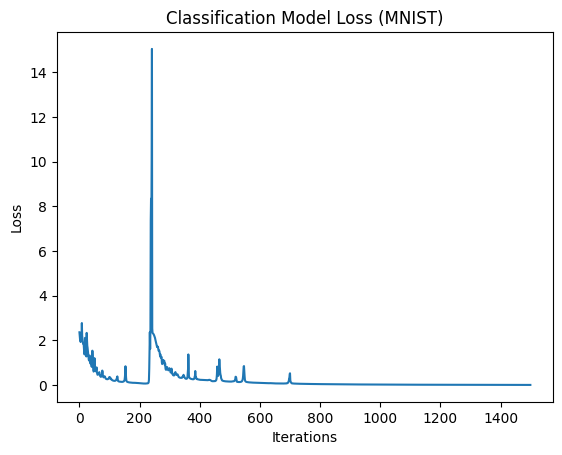

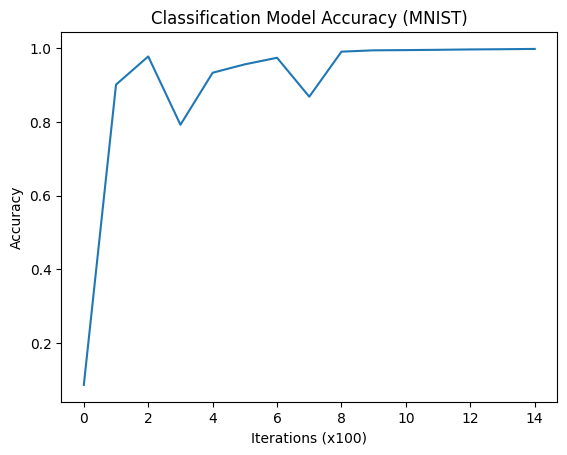

In [28]:
I_clf = x_train_clf.shape[0] 
O_clf = y_train_clf.shape[0] 
H1, H2, H3 = 64, 32, 16 

np.random.seed(seed)
init_params_clf = Initialization(I_clf, H1, H2, H3, O_clf)

# Train the model (using a small subset for speed in the test case)
m_sample = 5000
X_sample_train = x_train_clf[:, :m_sample]
y_sample_train = y_train_clf[:, :m_sample]



losses_clf, accuracies_clf, params_clf = training_clf(
    X_sample_train, 
    y_sample_train, 
    init_params_clf, 
    eta=0.5,         
    num_iters=1500,  
    lmbda=0.0       
)
plt.plot(losses_clf)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Classification Model Loss (MNIST)')
plt.show()

plt.plot(accuracies_clf)
plt.ylabel('Accuracy')
plt.xlabel('Iterations (x100)')
plt.title('Classification Model Accuracy (MNIST)')
plt.show()

In [29]:
#Sample test case
assert losses_clf[-1] < losses_clf[0]
print('Sample Test passed', '\U0001F44D')

y_pred_test_clf, _ = feed_forward_clf(x_test_clf, params_clf)
predictions_test = np.argmax(y_pred_test_clf, axis=0)
true_labels_test = np.argmax(y_test_clf, axis=0)
test_acc = accuracy_score(true_labels_test, predictions_test)
print(f"Final Test Accuracy (MNIST): {test_acc * 100:.2f}%")

Sample Test passed 👍
Final Test Accuracy (MNIST): 91.42%


## 3.1 Analysis: SGD vs. Batch Gradient Descent

In [30]:
def training_clf_sgd(X, yd, parameters, eta=0.05, num_epochs=5, lmbda=0.1):
    '''
    Trains the classification model using SGD (4-layer version).
    Iterate one sample at a time.
    '''
    epoch_losses = []
    m = X.shape[1]
    
    # Unpack 4 layers
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters

    for epoch in tqdm(range(num_epochs)):
        epoch_loss_sum = 0
        
        # Shuffle data for each epoch
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        y_shuffled = yd[:, permutation]
        
        # Limit to 2000 samples for speed in this assignment context
        limit = min(m, 2000)

        for i in range(limit):
            # Get a single sample (m=1)
            Xi = X_shuffled[:, i:i+1]
            yi = y_shuffled[:, i:i+1]
            
            current_params = [W1, b1, W2, b2, W3, b3, W4, b4]
            y_pred, cache = feed_forward_clf(Xi, current_params)

            loss = cross_entropy_loss(y_pred, yi)
            reg_loss = regularization_L2(lmbda, W1, W2, W3, W4, 1) 
            epoch_loss_sum += (loss + reg_loss)

            grads = Backpropagation_clf(Xi, yi, cache, current_params, lmbda)

            W1 -= eta * grads["dW1"]
            b1 -= eta * grads["db1"]
            W2 -= eta * grads["dW2"]
            b2 -= eta * grads["db2"]
            W3 -= eta * grads["dW3"]
            b3 -= eta * grads["db3"]
            W4 -= eta * grads["dW4"]
            b4 -= eta * grads["db4"]
        
        # Average loss for the processed samples
        epoch_losses.append(epoch_loss_sum / limit)

    parameters_final = [W1, b1, W2, b2, W3, b3, W4, b4]
    return epoch_losses, parameters_final

Running Batch Gradient Descent...
Parameters initialized with He Initialization.


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


Running Stochastic Gradient Descent...
Parameters initialized with He Initialization.


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


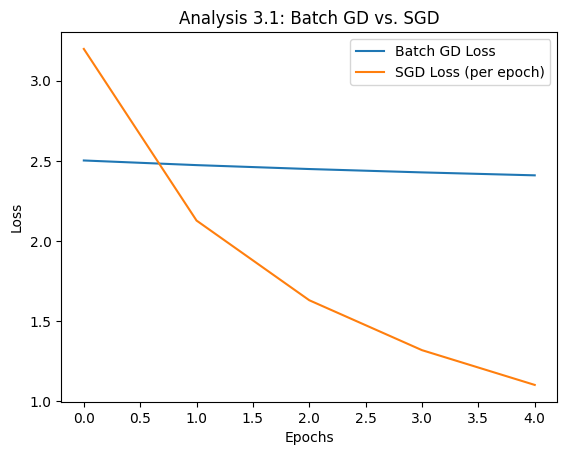

In [31]:
# --- Run Batch GD ---
print("Running Batch Gradient Descent...")
np.random.seed(seed)
H1, H2, H3, H4 = 64, 128, 64, 16 

init_params_batch = Initialization(I_clf, H1, H2, H3, O_clf)

losses_batch, accuracies_batch, parameters_final_batch = training_clf(X_sample_train, y_sample_train, init_params_batch, eta=0.01, num_iters=5, lmbda=0.01)

# --- Run SGD ---
print("Running Stochastic Gradient Descent...")
np.random.seed(seed)

init_params_sgd = Initialization(I_clf, H1, H2, H3, O_clf)

losses_sgd, parameters_final_sgd = training_clf_sgd(X_sample_train, y_sample_train, init_params_sgd, eta=0.01, num_epochs=5, lmbda=0.01)

# --- Plot Results ---
plt.plot(losses_batch, label='Batch GD Loss')
plt.plot(losses_sgd, label='SGD Loss (per epoch)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Analysis 3.1: Batch GD vs. SGD')
plt.show()

## 3.2 Analysis: Activation Functions (ReLU vs. Sigmoid)

In [32]:
import numpy as np

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def dsigmoid(x):
    s = sigmoid(x) 
    return s * (1 - s)


In [33]:
def feed_forward_flexible(X, params, hidden_activation='relu'):
    '''
    Forward pass with selectable hidden activation (4-layer).
    Layer 4 (Output) is always softmax.
    '''
    W1, b1, W2, b2, W3, b3, W4, b4 = params
    cache = []
    A0 = X
    
    # Select activation function
    g = relu 
    if hidden_activation == 'sigmoid':
        g = sigmoid
        
    # Layer 1
    Z1 = W1 @ A0 + b1
    A1 = g(Z1)           
    
    # Layer 2
    Z2 = W2 @ A1 + b2
    A2 = g(Z2)
    
    # Layer 3
    Z3 = W3 @ A2 + b3
    A3 = g(Z3)
    
    # Layer 4 (Output)
    Z4 = W4 @ A3 + b4
    A4 = softmax(Z4)
    
    for x in [Z1, A1, Z2, A2, Z3, A3, Z4, A4]:
        cache.append(x)
        
    y_out = A4
    return y_out, cache

In [34]:
def Backpropagation_flexible(X, yd, cache, parameters, lmbda, hidden_activation='relu'):
    '''
    Full backward pass with selectable hidden activation (4-layer).
    
    Inputs:
    - hidden_activation: 'relu' or 'sigmoid' (controls derivative used for hidden layers)
    '''
    # Select derivative function handle
    # Default is drelu, switch to dsigmoid if specified
    dg = drelu
    if hidden_activation == 'sigmoid':
        dg = dsigmoid

    m = X.shape[1]
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = cache
    grads = {}

    # Layer 4 (Output) - Fixed: Softmax + Cross Entropy
    # The derivative of Cost w.r.t Z4 is always (A4 - Y)
    dZ4 = (1/m) * (A4 - yd)
    dW4 = dZ4 @ A3.T + (lmbda/m) * W4
    db4 = np.sum(dZ4, axis=1, keepdims=True)
    dA3 = W4.T @ dZ4  # Propagate gradient to previous layer

    # Layer 3 (Hidden) - Flexible Activation
    # We use 'dg' which holds the correct derivative function
    dZ3 = dA3 * dg(Z3)
    dW3 = dZ3 @ A2.T + (lmbda/m) * W3
    db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = W3.T @ dZ3

    # Layer 2 (Hidden) - Flexible Activation
    dZ2 = dA2 * dg(Z2)
    dW2 = dZ2 @ A1.T + (lmbda/m) * W2
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = W2.T @ dZ2

    # Layer 1 (Hidden) - Flexible Activation
    dZ1 = dA1 * dg(Z1)
    dW1 = dZ1 @ X.T + (lmbda/m) * W1  # X is A0
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    # Store gradients
    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    grads['dW4'] = dW4
    grads['db4'] = db4
    
    return grads


In [35]:
def training_flexible(X, yd, parameters, eta=0.05, num_iters=3000, lmbda=0.1, hidden_activation='relu'):
    '''
    Trains the classification model with selectable hidden activation (4-layer).
    '''
    losses = []
    m = X.shape[1]
    
    # Unpack parameters to manage updates easily
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters

    for i in tqdm(range(num_iters)):
        
        # 1. Prepare parameters list for this iteration
        # (We repack them to ensure the functions get the most current weights)
        current_params = [W1, b1, W2, b2, W3, b3, W4, b4]
        
        # 2. Forward Pass (Flexible)
        y_out, cache = feed_forward_flexible(X, current_params, hidden_activation)
        
        # 3. Compute Loss
        # Cross-Entropy Loss for Classification
        cost = cross_entropy_loss(y_out, yd)
        # Add L2 Regularization term
        reg_cost = regularization_L2(lmbda, W1, W2, W3, W4, m)
        total_loss = cost + reg_cost
        losses.append(total_loss)
        
        # 4. Backward Pass (Flexible)
        grads = Backpropagation_flexible(X, yd, cache, current_params, lmbda, hidden_activation)
        
        # 5. Update Parameters (Gradient Descent)
        W1 -= eta * grads["dW1"]
        b1 -= eta * grads["db1"]
        W2 -= eta * grads["dW2"]
        b2 -= eta * grads["db2"]
        W3 -= eta * grads["dW3"]
        b3 -= eta * grads["db3"]
        W4 -= eta * grads["dW4"]
        b4 -= eta * grads["db4"]
        
        # END TODO ###################
            
    parameters_final = [W1, b1, W2, b2, W3, b3, W4, b4]
    return losses, parameters_final


Running Model with ReLU...
Parameters initialized with He Initialization.


100%|██████████| 500/500 [00:32<00:00, 15.54it/s]


Running Model with Sigmoid...
Parameters initialized with He Initialization.


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


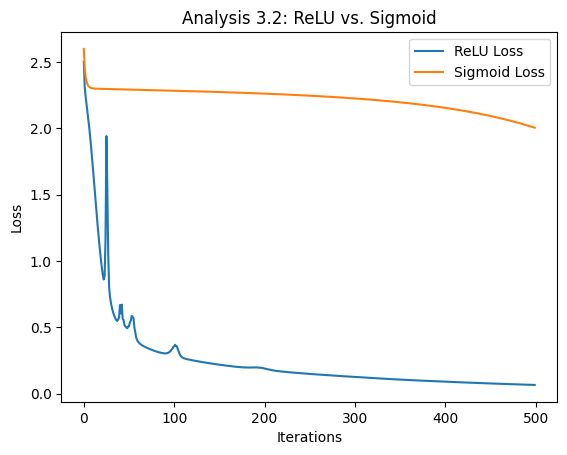

In [36]:
# --- Run ReLU Model --- 
print("Running Model with ReLU...")
np.random.seed(seed)
init_params_relu = Initialization(I_clf, H1, H2, H3, O_clf)
losses_relu, params_relu = training_flexible(X_sample_train, y_sample_train, init_params_relu, 
                                               eta=0.1, num_iters=500, lmbda=0.01, hidden_activation='relu')

# --- Run Sigmoid Model --- 
print("Running Model with Sigmoid...")
np.random.seed(seed)
init_params_sigmoid = Initialization(I_clf, H1, H2, H3, O_clf)
losses_sigmoid, params_sigmoid = training_flexible(X_sample_train, y_sample_train, init_params_sigmoid, 
                                                   eta=0.1, num_iters=500, lmbda=0.01, hidden_activation='sigmoid')

# --- Plot Results --- 
plt.plot(losses_relu, label='ReLU Loss')
plt.plot(losses_sigmoid, label='Sigmoid Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Analysis 3.2: ReLU vs. Sigmoid')
plt.show()

## 3.3 Analysis: Learning Rate (Eta)

Running LR=1.0 (High)...
Parameters initialized with He Initialization.


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Running LR=0.1 (Medium)...
Parameters initialized with He Initialization.


100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


Running LR=0.001 (Low)...
Parameters initialized with He Initialization.


100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


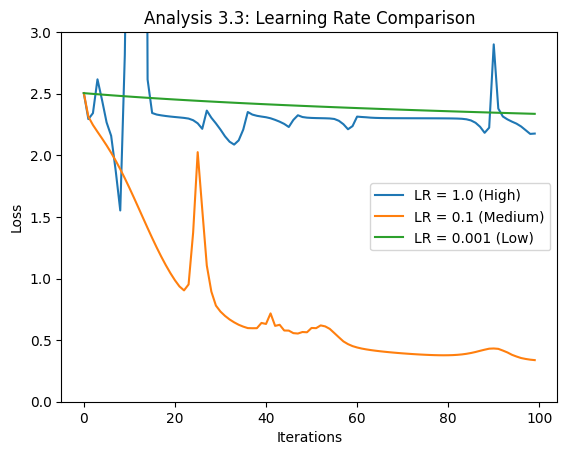

In [37]:
# --- Run LR Analysis --- 
# Note: Using the *full* training set now
print("Running LR=1.0 (High)...")
np.random.seed(seed)
init_params_lr1 = Initialization(I_clf, H1, H2, H3, O_clf)
losses_lr_high, _, _ = training_clf(x_train_clf, y_train_clf, init_params_lr1, eta=1.0, num_iters=100, lmbda=0.01)

print("Running LR=0.1 (Medium)...")
np.random.seed(seed)
init_params_lr2 = Initialization(I_clf, H1, H2, H3, O_clf)
losses_lr_med, _, _ = training_clf(x_train_clf, y_train_clf, init_params_lr2, eta=0.1, num_iters=100, lmbda=0.01)

print("Running LR=0.001 (Low)...")
np.random.seed(seed)
init_params_lr3 = Initialization(I_clf, H1, H2, H3, O_clf)
losses_lr_low, _, _ = training_clf(x_train_clf, y_train_clf, init_params_lr3, eta=0.001, num_iters=100, lmbda=0.01)

# --- Plot Results --- 
plt.plot(losses_lr_high, label='LR = 1.0 (High)')
plt.plot(losses_lr_med, label='LR = 0.1 (Medium)')
plt.plot(losses_lr_low, label='LR = 0.001 (Low)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Analysis 3.3: Learning Rate Comparison')
plt.ylim(0, 3) # Limit y-axis to see the differences better
plt.show()

## 3.4 Analysis: Overfitting and Regularization (Lambda)

The lecture slides mentioned **Overfitting** as a key problem in large networks. L2 Regularization (controlled by $\lambda$) is a technique to combat this.

**Your Task:**
1.  Train two models using `training_clf` (with ReLU, $\eta=0.1$) on the **full training set** for 1000 iterations.
    * Run 1: **With Regularization** ($\lambda = 0.1$)
    * Run 2: **Without Regularization** ($\lambda = 0$)
2.  For *each* of the two trained models, calculate and record:
    * The final **Training Accuracy** (on `x_train_clf`).
    * The final **Test Accuracy** (on `x_test_clf`).
3.  **Analyze:** In your report, present these 4 accuracy numbers (e.g., in a small table). 
    * Which model had a *higher* training accuracy? 
    * Which model had a *higher* test accuracy?
    * Did the model without regularization show signs of **overfitting** (a large gap between training and test accuracy)? Explain how L2 regularization helps prevent this.

In [38]:
# --- Run Regularization Analysis --- 
num_iters_reg = 1000
eta_reg = 0.1

print("Running WITH Regularization (lambda=0.1)...")
np.random.seed(seed)
init_params_with_reg = Initialization(I_clf, H1, H2, H3, O_clf)
_, _, params_with_reg = training_clf(x_train_clf, y_train_clf, init_params_with_reg, 
                                      eta=eta_reg, num_iters=num_iters_reg, lmbda=0.1)

print("Running WITHOUT Regularization (lambda=0)...")
np.random.seed(seed)
init_params_no_reg = Initialization(I_clf, H1, H2, H3, O_clf)
_, _, params_no_reg = training_clf(x_train_clf, y_train_clf, init_params_no_reg, 
                                   eta=eta_reg, num_iters=num_iters_reg, lmbda=0)

# --- Calculate Accuracies --- 
print("\nCalculating accuracies...")

# Model WITH Regularization
y_pred_train_with_reg, _ = feed_forward_clf(x_train_clf, params_with_reg)
acc_train_with_reg = accuracy_score(np.argmax(y_train_clf, axis=0), np.argmax(y_pred_train_with_reg, axis=0))
y_pred_test_with_reg, _ = feed_forward_clf(x_test_clf, params_with_reg)
acc_test_with_reg = accuracy_score(np.argmax(y_test_clf, axis=0), np.argmax(y_pred_test_with_reg, axis=0))

# Model WITHOUT Regularization
y_pred_train_no_reg, _ = feed_forward_clf(x_train_clf, params_no_reg)
acc_train_no_reg = accuracy_score(np.argmax(y_train_clf, axis=0), np.argmax(y_pred_train_no_reg, axis=0))
y_pred_test_no_reg, _ = feed_forward_clf(x_test_clf, params_no_reg)
acc_test_no_reg = accuracy_score(np.argmax(y_test_clf, axis=0), np.argmax(y_pred_test_no_reg, axis=0))

print("--- Analysis 3.4 Results ---")
print(f"WITH Regularization (lambda=0.1):")
print(f"  Training Accuracy: {acc_train_with_reg * 100:.2f}%")
print(f"  Test Accuracy:     {acc_test_with_reg * 100:.2f}%")
print(f"  Gap:               {(acc_train_with_reg - acc_test_with_reg) * 100:.2f}%")
print("\nWITHOUT Regularization (lambda=0):")
print(f"  Training Accuracy: {acc_train_no_reg * 100:.2f}%")
print(f"  Test Accuracy:     {acc_test_no_reg * 100:.2f}%")
print(f"  Gap:               {(acc_train_no_reg - acc_test_no_reg) * 100:.2f}%")


Running WITH Regularization (lambda=0.1)...
Parameters initialized with He Initialization.


100%|██████████| 1000/1000 [15:30<00:00,  1.07it/s]


Running WITHOUT Regularization (lambda=0)...
Parameters initialized with He Initialization.


100%|██████████| 1000/1000 [25:37<00:00,  1.54s/it]   



Calculating accuracies...
--- Analysis 3.4 Results ---
WITH Regularization (lambda=0.1):
  Training Accuracy: 96.93%
  Test Accuracy:     95.92%
  Gap:               1.01%

WITHOUT Regularization (lambda=0):
  Training Accuracy: 96.93%
  Test Accuracy:     95.93%
  Gap:               1.00%


## 3.5 Analysis: The Impact of Initialization

--- Training with He Initialization ---
Parameters initialized with He Initialization.


100%|██████████| 500/500 [06:40<00:00,  1.25it/s]



--- Training with Bad Initialization (0.01) ---


100%|██████████| 500/500 [04:05<00:00,  2.03it/s]


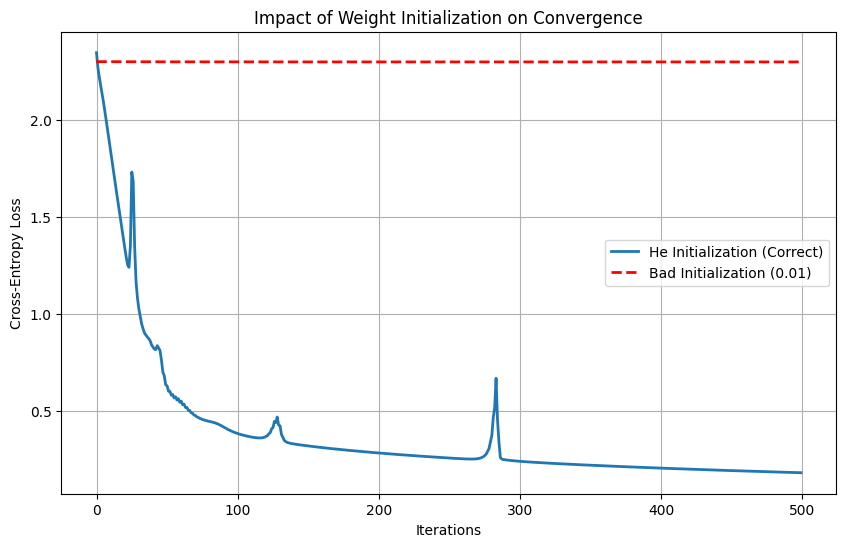

In [39]:
# 1. Define 'Bad' Initialization Function (Small Weights)
def Initialization_Bad(I, H1, H2, H3, O):
    '''
    Initializes weights with very small random numbers (0.01 scale).
    This simulates the Vanishing Gradient problem conditions.
    '''
    np.random.seed(42) 
    scale = 0.01  # The "Bad" scale factor
    
    W1 = np.random.randn(H1, I) * scale
    b1 = np.zeros((H1, 1))
    
    W2 = np.random.randn(H2, H1) * scale
    b2 = np.zeros((H2, 1))
    
    W3 = np.random.randn(H3, H2) * scale
    b3 = np.zeros((H3, 1))
    
    W4 = np.random.randn(O, H3) * scale
    b4 = np.zeros((O, 1))
    
    return [W1, b1, W2, b2, W3, b3, W4, b4]

# 2. Setup Dimensions
I, O = 784, 10
H1, H2, H3 = 64, 32, 16

# 3. Experiment 1: He Initialization (Baseline)
print("--- Training with He Initialization ---")
params_he = Initialization(I, H1, H2, H3, O)
# Note: Using your classification training function (training_flexible or training_clf)
losses_he, _ = training_flexible(
    x_train_clf, y_train_clf, 
    params_he, 
    eta=0.1, 
    num_iters=500, 
    lmbda=0.1, 
    hidden_activation='relu'
)

# 4. Experiment 2: Bad Initialization (Small Random)
print("\n--- Training with Bad Initialization (0.01) ---")
params_bad = Initialization_Bad(I, H1, H2, H3, O)
losses_bad, _ = training_flexible(
    x_train_clf, y_train_clf, 
    params_bad, 
    eta=0.1, 
    num_iters=500, 
    lmbda=0.1, 
    hidden_activation='relu'
)

# 5. Visualization
plt.figure(figsize=(10, 6))
plt.plot(losses_he, label='He Initialization (Correct)', linewidth=2)
plt.plot(losses_bad, label='Bad Initialization (0.01)', linewidth=2, linestyle='--', color='red')
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy Loss')
plt.title('Impact of Weight Initialization on Convergence')
plt.legend()
plt.grid(True)
plt.show()
